# Wrangle and Analyze Data

# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import json
import datetime
import requests
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
from subprocess import call
from tqdm import trange,tqdm

# 2. Gathering Data

## 2.1 WeRateDogs Twitter archive

In [2]:
df1 = pd.read_csv('twitter-archive-enhanced.csv')
df1.shape

(2356, 17)

In [3]:
df1.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


## 2.2 Tweet image predictions

In [4]:
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
get_requests = requests.get(URL)
with open (URL.split('/')[-1], mode='wb') as file:
    file.write(get_requests.content)

In [5]:
df2 = pd.read_csv('image-predictions.tsv', sep='\t')
df2.shape

(2075, 12)

In [6]:
df2.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


## 2.3 tweet's retweet count and favorite

In [7]:
with open('creds.json') as f:
    twitter_creds = json.load(f)

In [8]:
### Authentication
auth = OAuthHandler(twitter_creds['API_KEY'], twitter_creds['API_SECRET_KEY'])
auth.set_access_token(twitter_creds['ACCESS_TOKEN'], twitter_creds['ACCESS_TOKEN_SECRET'])
api = tweepy.API(auth, parser = tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

In [45]:
### Twitter query
with open('tweet_json.txt', 'w') as json_file:
    for tweet_id in tqdm(df1.tweet_id.unique()):
        try:
            status = api.get_status(tweet_id)
            json_file.write(json.dumps(status))
            json_file.write('\n')
        except tweepy.TweepError as e:
            pass

100%|██████████| 2356/2356 [35:02<00:00,  1.12it/s]   


In [9]:
### Read json file
df3 = pd.DataFrame(columns=['tweet_id','retweet_count','favorite_count','followers_count','retweeted_status','url'])
with open('tweet_json.txt', encoding='utf-8') as json_file:
    for status in json_file:
        data = json.loads(status)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']        
        followers_count = data['user']['followers_count']
        full_text = data['text']
        original_url = full_text[full_text.find('https'):]
        retweeted_status = data['retweeted_status'] = data.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = original_url
        else:
            retweeted_status = 'Retweet'
            url = 'Retweet'
        tweet_dict = {'tweet_id': tweet_id,'retweet_count': retweet_count,'favorite_count': favorite_count,'followers_count': followers_count,'retweeted_status': retweeted_status,'url': url}
        df3 = df3.append(tweet_dict, ignore_index=True)
df3.shape

(2328, 6)

In [10]:
df3.head(2)

,tweet_id,retweet_count,favorite_count,followers_count,retweeted_status,url
0,892420643555336193,7237,34675,9001806,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,5420,30046,9001806,Original tweet,https://t.co/aQFSeaCu9L


# 3. Assessing Data

### Head

In [11]:
df1.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [12]:
df2.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [13]:
df3.head(2)

,tweet_id,retweet_count,favorite_count,followers_count,retweeted_status,url
0,892420643555336193,7237,34675,9001806,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,5420,30046,9001806,Original tweet,https://t.co/aQFSeaCu9L


### Null values

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2328 non-null   object
 1   retweet_count     2328 non-null   object
 2   favorite_count    2328 non-null   object
 3   followers_count   2328 non-null   object
 4   retweeted_status  2328 non-null   object
 5   url               2328 non-null   object
dtypes: object(6)
memory usage: 109.2+ KB


---> We can see that only df1 has null values, so we have to make an analysis

### Duplicates

In [17]:
df1[df1.duplicated()].shape

(0, 17)

In [18]:
df2[df2.duplicated()].shape

(0, 12)

In [19]:
df3[df3.duplicated()].shape

(0, 6)

### Statistical description

In [20]:
df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [21]:
df2.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [22]:
df3.describe()

,tweet_id,retweet_count,favorite_count,followers_count,retweeted_status,url
count,2328,2328,2328,2328,2328,2328
unique,2328,1670,1958,36,2,2132
top,891815181378084864,494,0,9001814,Original tweet,Retweet
freq,1,6,161,295,2167,161


### Unique values

In [23]:
df1.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [24]:
df2.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [25]:
df3.nunique()

tweet_id            2328
retweet_count       1670
favorite_count      1958
followers_count       36
retweeted_status       2
url                 2132
dtype: int64

In [26]:
df1.name.value_counts()

None            745
a                55
Charlie          12
Oliver           11
Cooper           11
               ... 
Kanu              1
Stefan            1
Hall              1
Dunkin            1
Cleopatricia      1
Name: name, Length: 957, dtype: int64

In [27]:
df1.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [28]:
df1.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [29]:
df1.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [30]:
df1.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [31]:
df2.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
killer_whale            1
trombone                1
bib                     1
dining_table            1
bow                     1
Name: p1, Length: 378, dtype: int64

In [32]:
df3.retweeted_status.value_counts()

Original tweet    2167
Retweet            161
Name: retweeted_status, dtype: int64

---
After this analysis we can say:
 1) **df1 (Archive data)**
  - **Quality Issue:**
      1) **Null values** in [in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls]
      2) **tweet_id** column has *int* type, but the other "id" columns have float type, so to be consistent we have to convert all "id" columns to *float* type.
      3) **timestamp** and **retweeted_status_timestamp** columns have *object* type, but that columns must have *timestamp* type.
      4) **name** column has 745 rows with "None" value and 55 values with "a" value.
  - **Tidiness Issue:**
      1) One variable is spread across four different columns (**doggo**, **floofer**, **pupper** and **puppo** columns). These four columns should be combined into a single column as this is one variable that identify stage of dog.
 2) **df2 (Image data)**
  - **Quality Issue:**
      1) **p1**, **p2** and **p3** have invalid data, there are rows with cases such as laptop, restaurant, basketball, tricycle, etc.
      2) **p1_conf**, **p2_conf** and **p3_conf** have lower values (near to zero), so this indicates that there are predictions made with underestimation.
      3) In order to merge with the other dataframes, we have to change the **tweet_id** column's type to *float*.
 3) **df3 (tweet's retweet info)**
  - **Quality Issue:**
      1) There are 161 retweets.
      2) In order to merge with the other dataframes, we have to change the **tweet_id** column's type to *float*.
  - **Tidiness Issue:**
      1) We have to merge the three datasets.

# 4. Cleaning Data

## 4.1 Copying of the original pieces of data

In [33]:
archive_data = df1.copy()
image_data = df2.copy()
tweets_info_data = df3.copy()

## 4.2 Merge the three datasets

### 4.2.1 Define
 - Merge with *concat* method

### 4.2.2 Code

In [34]:
df_merge = pd.concat([df1, df2, df3], join='outer', axis=1)

### 4.2.3 Test

In [35]:
df_merge.shape

(2356, 35)

In [36]:
df_merge.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_dog,p3,p3_conf,p3_dog,tweet_id,retweet_count,favorite_count,followers_count,retweeted_status,url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,True,Shetland_sheepdog,0.061428,True,892420643555336193,7237,34675,9001806,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Rhodesian_ridgeback,0.072010,True,892177421306343426,5420,30046,9001806,Original tweet,https://t.co/aQFSeaCu9L


## 4.3 Duplicated columns

### 4.3.1 Define
 - *tweet_id* column appears three times due to the merge of dataframes, so we have to remove duplicated columns

In [37]:
df_merge.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'tweet_id',
       'retweet_count', 'favorite_count', 'followers_count',
       'retweeted_status', 'url'],
      dtype='object')

### 4.3.2 Code

In [38]:
df_merge = df_merge.loc[:,~df_merge.columns.duplicated()]

### 4.3.3 Test

In [39]:
df_merge.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count',
       'followers_count', 'retweeted_status', 'url'],
      dtype='object')

In [40]:
df_merge.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,retweeted_status,url
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.156665,True,Shetland_sheepdog,0.061428,True,7237,34675,9001806,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.074192,True,Rhodesian_ridgeback,0.072010,True,5420,30046,9001806,Original tweet,https://t.co/aQFSeaCu9L


## 4.4 doggo, floofer, pupper, puppo columns

### 4.4.1 Define
 - One variable is spread across four different columns (doggo, floofer, pupper and puppo columns). These four columns should be combined into a single column as this is one variable that identify stage of dog.

### 4.4.2 Code

In [41]:
for col in ['doggo','floofer','pupper','puppo']:
    df_merge[col] = df_merge[col].replace('None', '')

In [42]:
df_merge['stage'] = df_merge.doggo + df_merge.floofer + df_merge.pupper + df_merge.puppo

In [43]:
df_merge.loc[df_merge['stage'] == 'doggopupper', 'stage'] = 'doggo,pupper' 
df_merge.loc[df_merge['stage'] == 'doggopuppo', 'stage'] = 'doggo,puppo' 
df_merge.loc[df_merge['stage'] == 'doggofloofer', 'stage'] = 'doggo,floofer'

In [49]:
df_merge = df_merge.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

### 4.4.3 Test

In [50]:
df_merge.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,retweeted_status,url,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,True,Shetland_sheepdog,0.061428,True,7237,34675,9001806,Original tweet,https://t.co/MgUWQ76dJU,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Rhodesian_ridgeback,0.072010,True,5420,30046,9001806,Original tweet,https://t.co/aQFSeaCu9L,


## 4.5 Dropping duplicated tweets

### 4.5.1 Define
 - We only want original dog ratings. So have to remove retweets as a user can retweet their on tweet.

In [45]:
df_merge.shape

(2356, 34)

### 4.5.2 Code

In [46]:
df_merge = df_merge[df_merge.retweeted_status_id.isnull()]
df_merge = df_merge[df_merge.retweeted_status_user_id.isnull()]
df_merge = df_merge[df_merge.retweeted_status_timestamp.isnull()]

### 4.5.3 Test

In [48]:
df_merge.shape

(2175, 34)

## 4.6 Remove null values

### 4.6.1 Define
 - Remove columns with missing data

### 4.6.2 Code

In [51]:
df_merge = df_merge.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis=1)

### 4.6.3 Test

In [52]:
df_merge.shape

(2175, 24)

In [53]:
df_merge.head(2)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,...,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,retweeted_status,url,stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,Welsh_springer_spaniel,...,True,Shetland_sheepdog,0.061428,True,7237,34675,9001806,Original tweet,https://t.co/MgUWQ76dJU,
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,...,True,Rhodesian_ridgeback,0.072010,True,5420,30046,9001806,Original tweet,https://t.co/aQFSeaCu9L,


## 4.7 Column types

### 4.7.1 Define
 - Convert columns to their correct types

### 4.7.2 Code

In [54]:
df_merge['tweet_id'] = df_merge['tweet_id'].astype(str)
df_merge['timestamp'] = pd.to_datetime(df_merge['timestamp'])
df_merge['retweet_count'] = df_merge['retweet_count'].astype(float)
df_merge['favorite_count'] = df_merge['favorite_count'].astype(float)
df_merge['followers_count'] = df_merge['followers_count'].astype(float)

### 4.7.3 Test

In [55]:
df_merge.dtypes

tweet_id                           object
timestamp             datetime64[ns, UTC]
source                             object
text                               object
rating_numerator                    int64
rating_denominator                  int64
name                               object
jpg_url                            object
img_num                           float64
p1                                 object
p1_conf                           float64
p1_dog                             object
p2                                 object
p2_conf                           float64
p2_dog                             object
p3                                 object
p3_conf                           float64
p3_dog                             object
retweet_count                     float64
favorite_count                    float64
followers_count                   float64
retweeted_status                   object
url                                object
stage                             

## 4.8 Quality issue

### 4.8.1 Define
 - *name* column has 745 rows with "None" value and other values with lowercase text that are not dog names.

### 4.6.2 Code

In [56]:
df_merge['name'] = df_merge['name'].replace(['None'], np.nan)

In [58]:
mask

0       False
1       False
2       False
3       False
4       False
        ...  
2351      NaN
2352     True
2353     True
2354     True
2355      NaN
Name: name, Length: 2175, dtype: object

In [60]:
df_merge.loc[df_merge['name'].str.islower() == True, 'name'] = np.nan

### 4.6.3 Test

In [61]:
df_merge[df_merge['name'] == 'None'].shape

(0, 24)

In [62]:
df_merge[df_merge['name'] == 'a'].shape

(0, 24)

In [63]:
df_merge[df_merge['name'] == 'the'].shape

(0, 24)

In [64]:
df_merge[df_merge['name'] == 'such'].shape

(0, 24)

# 5. Storing, Analyzing, and Visualizing Data

## 5.1 Storing cleaned data in a CSV file

In [66]:
df_merge.to_csv('twitter_archive_master.csv', index=False)

## 5.2 Storing cleaned data in a SQL Lite database

In [67]:
from sqlalchemy import create_engine

In [68]:
# Create SQLAlchemy Engine and empty bestofrt database
engine = create_engine('sqlite:///bestofrt.db')

In [69]:
# Store cleaned master DataFrame ('df') in a table called table_cleaned_data in bestofrt.db
df_merge.to_sql('table_cleaned_data', engine, if_exists='replace',index=False)

## 5.3 Visualizing Data

In [70]:
df_merge.head(2)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,jpg_url,img_num,p1,...,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,followers_count,retweeted_status,url,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,Welsh_springer_spaniel,...,True,Shetland_sheepdog,0.061428,True,7237.0,34675.0,9001806.0,Original tweet,https://t.co/MgUWQ76dJU,
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,...,True,Rhodesian_ridgeback,0.072010,True,5420.0,30046.0,9001806.0,Original tweet,https://t.co/aQFSeaCu9L,


### 5.3.1 tweets over time

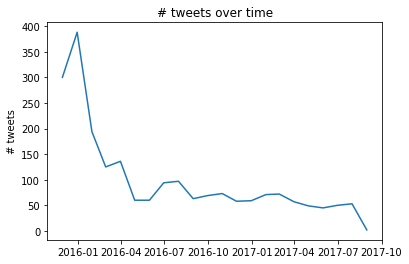

In [71]:
data_group = df_merge.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
data_group = data_group[['timestamp', 'tweet_id']]
plt.plot(data_group['timestamp'], data_group['tweet_id'])
plt.title('# tweets over time')
plt.ylabel('# tweets')
plt.savefig('tweets_over_time')
plt.show()

 - **Insight**: Through time, the number of tweets has decreased, in 2016 there were almost 400 tweets per month, however in 2017 this quantity decreased near to zero.

### 5.3.2 retweet and favorite count over time

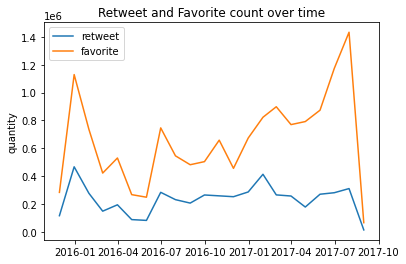

In [72]:
data_group = df_merge.groupby(pd.Grouper(key = 'timestamp', freq = "M")).agg({'retweet_count':'sum', 'favorite_count':'sum'}).reset_index()
plt.plot(data_group['timestamp'], data_group['retweet_count'])
plt.plot(data_group['timestamp'], data_group['favorite_count'])
plt.title('Retweet and Favorite count over time')
plt.ylabel('quantity')
plt.legend(['retweet', 'favorite'], loc='upper left')
plt.savefig('retweet_favorite_count_over_time')
plt.show()

 - **Insight**: Through time, the number of retweets and favorites have followed a similar trend, the only difference is that the number of favorites has been greater than retweets.

### 5.3.3 Most common dog names

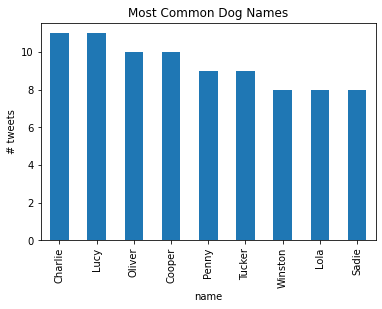

In [73]:
data_group = df_merge.groupby('name').agg({'tweet_id':'count'}).reset_index().sort_values(by='tweet_id', ascending=False)
data_group[0:9].plot(kind='bar',x='name', legend=False)
plt.title('Most Common Dog Names')
plt.ylabel('# tweets')
plt.savefig('dog_names_over_time')
plt.show()

 - **Insight**: Through time, Charlie, Lucy and Oliver are the three most common names.

### 5.3.4 Dog Stage

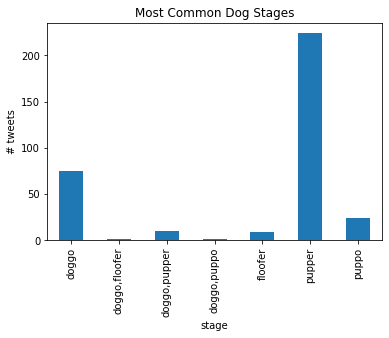

In [82]:
data_group = df_merge.groupby('stage').agg({'tweet_id':'count'}).reset_index()
data_group[data_group.stage != ''].plot(kind='bar',x='stage', legend=False)
plt.title('Most Common Dog Stages')
plt.ylabel('# tweets')
plt.savefig('dog_stage_count')
plt.show()

 - **Insight**: Through time, pupper is the most common dog stage.